# Calculating geostrophic flow

* **ANHA4 Grid SSH** ---(interp)---> **xygrid SSH** ---(finite diff)---> **xygrid geostrophic flow** ---(interp)---> **ANHA4 Grid geo. flow**

Equations
$$
u_g = -\frac{g}{f}\frac{\Delta H}{\Delta y}\\
v_g = \frac{g}{f}\frac{\Delta H}{\Delta x}
$$

Then
$$
\Delta x = R\Delta lon \cdot cos(lat) \\
\Delta y = R\Delta lat
$$


In [219]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [5]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import detrend
from scipy.stats.stats import pearsonr
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [226]:
def interp_np(xin, yin, zin, xout, yout):
    zout = Nts.reporj_NEMOgrid(xin, yin, zin, xout, yout, method='linear')
    zfill = Nts.reporj_NEMOgrid(xin, yin, zin, xout, yout, method='nearest')
    zout[np.isnan(zout)] = zfill[np.isnan(zout)]
    zout[yout>89.5] = np.nan
    return zout

In [298]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]
#
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')
ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan
ssh_mean = ssh[0, :, :]
#
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current.mat')
vozocrtx0 = MAT['vozocrtx0'][:]
vomecrty0 = MAT['vomecrty0'][:]
u_mean = vozocrtx0[0, :, :]
v_mean = vomecrty0[0, :, :]

In [299]:
x = np.linspace(-180, 180, 70)
y = np.linspace(20, 90, 70)
ocean_lon, ocean_lat = np.meshgrid(x, y)
ssh_regrid = interp_np(nav_lon, nav_lat, ssh_mean, ocean_lon, ocean_lat)
ug, vg = Ats.geo_wind(ocean_lon, ocean_lat, ssh_regrid)

In [300]:
ug_ANHA4 = Nts.reporj_NEMOgrid(ocean_lon, ocean_lat, ug, nav_lon, nav_lat, method='linear')
vg_ANHA4 = Nts.reporj_NEMOgrid(ocean_lon, ocean_lat, vg, nav_lon, nav_lat, method='linear')

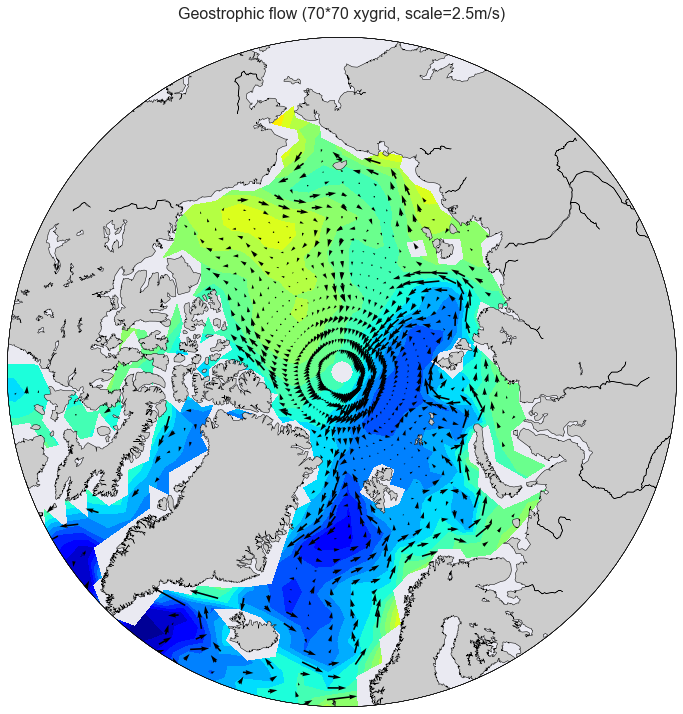

In [301]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
n = 1
proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')

uproj, vproj, x, y = proj.rotate_vector(ug, vg, ocean_lon, ocean_lat, returnxy=True)
proj.contourf(x, y, ssh_regrid, 25, cmap=plt.cm.jet)
Q = proj.quiver(x[::n, ::n], y[::n, ::n], uproj[::n, ::n], vproj[::n, ::n], scale=2.5)
ax.set_title('Geostrophic flow (70*70 xygrid, scale=2.5m/s)', fontsize=16, y=1.02)

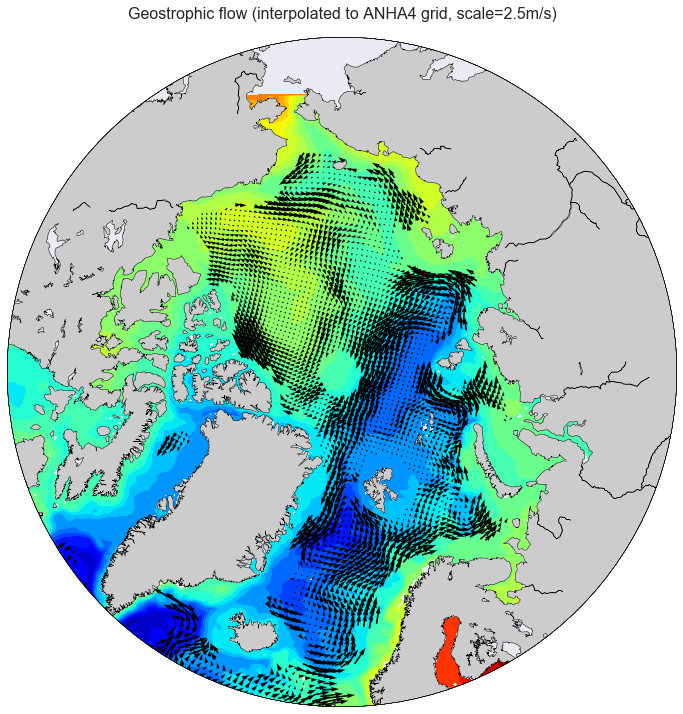

In [302]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
n = 4
proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')

uproj, vproj, x, y = proj.rotate_vector(ug_ANHA4, vg_ANHA4, nav_lon, nav_lat, returnxy=True)
proj.contourf(x, y, ssh_mean, 25, cmap=plt.cm.jet)
Q = proj.quiver(x[::n, ::n], y[::n, ::n], uproj[::n, ::n], vproj[::n, ::n], scale=2.5)
ax.set_title('Geostrophic flow (interpolated to ANHA4 grid, scale=2.5m/s)', fontsize=16, y=1.02)

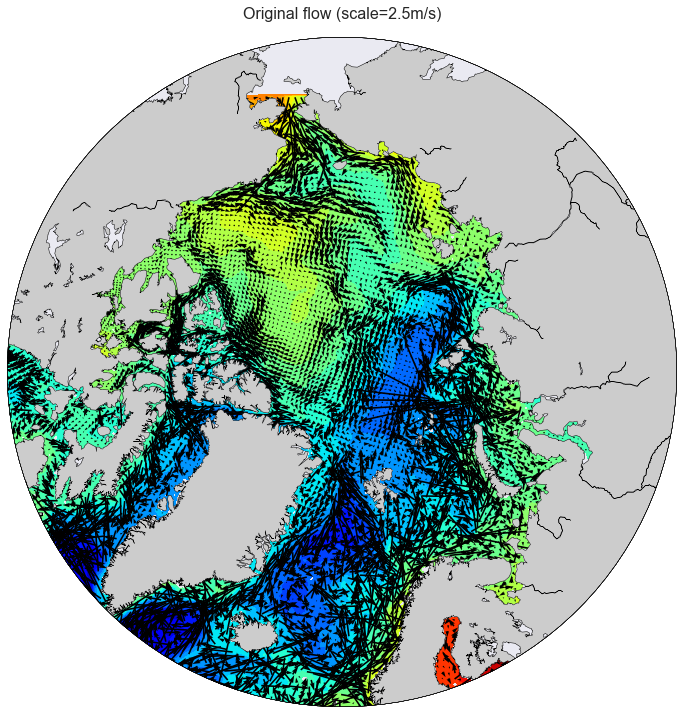

In [303]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
n = 4
proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')

uproj, vproj, x, y = proj.rotate_vector(u_mean, v_mean, nav_lon, nav_lat, returnxy=True)
proj.contourf(x, y, ssh_mean, 25, cmap=plt.cm.jet)
Q = proj.quiver(x[::n, ::n], y[::n, ::n], u_mean[::n, ::n], v_mean[::n, ::n], scale=2.5)
ax.set_title('Original flow (scale=2.5m/s)', fontsize=16, y=1.02)

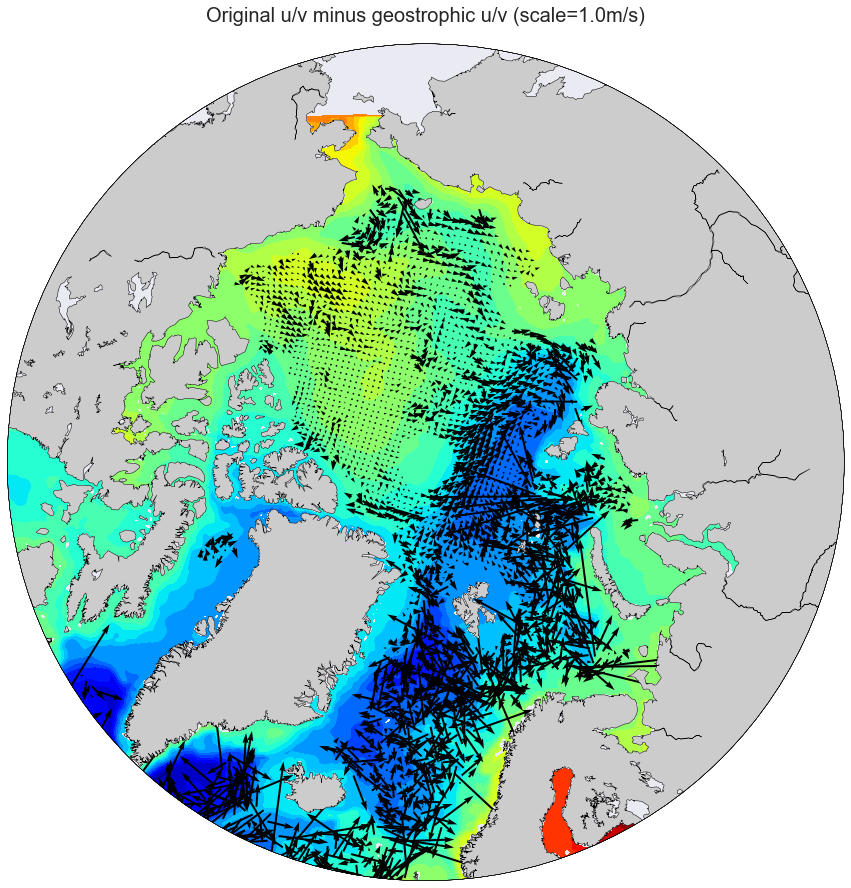

In [305]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
n = 4
proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')

uproj, vproj, x, y = proj.rotate_vector(ug_ANHA4, vg_ANHA4, nav_lon, nav_lat, returnxy=True)
proj.contourf(x, y, ssh_mean, 25, cmap=plt.cm.jet)
Q = proj.quiver(x[::n, ::n], y[::n, ::n], u_mean[::n, ::n]-uproj[::n, ::n], v_mean[::n, ::n]-vproj[::n, ::n], scale=2.0)
ax.set_title('Original u/v minus geostrophic u/v (scale=1.0m/s)', fontsize=20, y=1.02)